# **SALINAS COMAPRISON**

BASELINE FS

Feature extraction completed in 0.00 minutes
Inter-Class Classification Accuracy: 0.7766
Kappa Coefficient: 0.7199
Adjusted Rand Index: 0.5154
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.65      0.79     11395
           1       0.77      1.00      0.87       401
           2       0.83      1.00      0.91       745
           3       0.38      0.98      0.55       395
           4       0.36      1.00      0.53       278
           5       0.58      0.99      0.73       535
           6       0.85      1.00      0.92       791
           7       0.85      1.00      0.92       715
           8       0.76      0.74      0.75      2254
           9       0.59      0.99      0.74      1240
          10       0.78      0.97      0.86       655
          11       0.66      1.00      0.79       213
          12       0.55      1.00      0.71       385
          13       0.67      0.98      0.80       183
          14       0.69

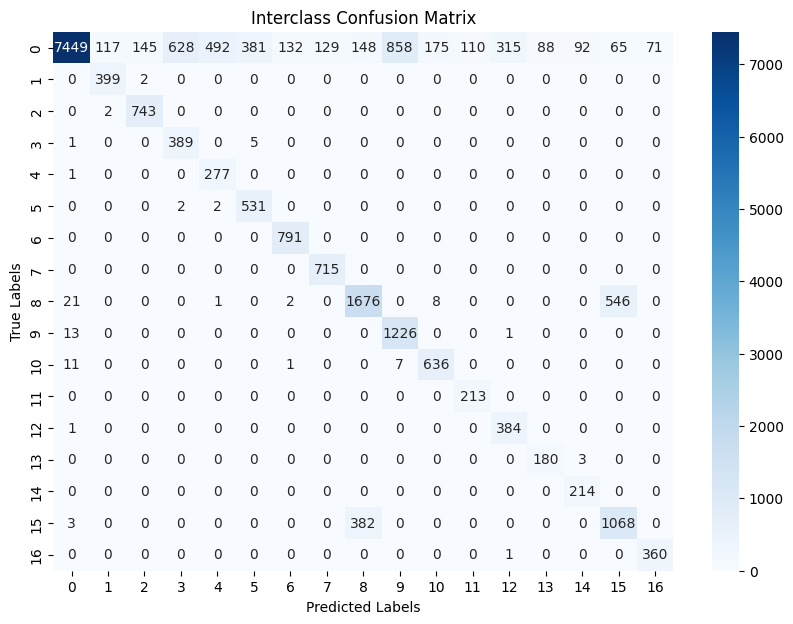

Average Interclass Distance in Latent Space: 9.9608
Classwise inter-class classification accuracy saved to /content/drive/MyDrive/Base_FS_classwise_accuracy.csv


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, cohen_kappa_score, adjusted_rand_score
import time
import os

# Define Spectral Feature Extractor (1D CNN)
class SpectralFeatureExtractor(nn.Module):
    def __init__(self):
        super(SpectralFeatureExtractor, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, 5, padding=2)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 64, 5, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc = nn.Linear(64 * 204, 128)  # 204 spectral bands

    def forward(self, x):
        x = x.unsqueeze(1)  # Convert (batch, 204) -> (batch, 1, 204)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

# Define Prototypical Network
class PrototypicalNetwork(nn.Module):
    def __init__(self):
        super(PrototypicalNetwork, self).__init__()
        self.feature_extractor = SpectralFeatureExtractor()

        def forward(self, support, query):
        support_embeddings = self.feature_extractor(support)
        query_embeddings = self.feature_extractor(query)

        prototypes = support_embeddings.view(n_way, k_shot, -1).mean(dim=1)

        # Ensure correct shape before computing distances
        query_embeddings = query_embeddings.view(-1, prototypes.shape[-1])

        dists = torch.cdist(query_embeddings, prototypes, p=2) ** 2
        return -dists

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained model
model_dir = "/content/drive/MyDrive/Model_Checkpoints"
model_path = os.path.join(model_dir, "PrototypicalNetwork_Salinas.pth")

model = PrototypicalNetwork().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()  # Set model to evaluation mode

# Load Spectral Data
spectral_data_path = "/content/drive/MyDrive/Salinas_Reduced.csv"
df_spectral = pd.read_csv(spectral_data_path)

X = df_spectral.iloc[:, :-1].values  # First 204 columns as features
y_spectral = df_spectral.iloc[:, -1].values   # Last column as labels (predicted classes)

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert to Torch Tensor
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)

# Feature extraction
start_time = time.time()
with torch.no_grad():
    feature_extractor = model.feature_extractor
    embeddings = feature_extractor(X_tensor).cpu().numpy()
end_time = time.time()
training_time = (end_time - start_time) / 60
print(f"Feature extraction completed in {training_time:.2f} minutes")

# Load Ground Truth Data
ground_truth_path = "/content/drive/MyDrive/Sal_sampled_gt.csv"
df_gt = pd.read_csv(ground_truth_path)
y_ground_truth = df_gt.iloc[:, -4].values

# Compute class prototypes
class_prototypes = {}
for cls in np.unique(y_ground_truth):
    class_indices = np.where(y_spectral == cls)[0]
    class_prototypes[cls] = embeddings[class_indices].mean(axis=0)

prototypes_tensor = torch.tensor(np.array(list(class_prototypes.values())), dtype=torch.float32, device=device)

# Classify test samples
def classify_samples(test_samples):
    test_samples = torch.tensor(test_samples, dtype=torch.float32, device=device)
    dists = torch.cdist(test_samples, prototypes_tensor, p=2)  # Euclidean distance
    predictions = torch.argmin(dists, dim=1).cpu().numpy()
    return predictions

y_pred = classify_samples(embeddings)

# Compute evaluation metrics
accuracy = accuracy_score(y_ground_truth, y_pred)
kappa = cohen_kappa_score(y_ground_truth, y_pred)
ari = adjusted_rand_score(y_ground_truth, y_pred)
print(f"Inter-Class Classification Accuracy: {accuracy:.4f}")
print(f"Kappa Coefficient: {kappa:.4f}")
print(f"Adjusted Rand Index: {ari:.4f}")
print("Classification Report:")
print(classification_report(y_ground_truth, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_ground_truth, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=np.unique(y_ground_truth), yticklabels=np.unique(y_ground_truth))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Interclass Confusion Matrix")
plt.show()

# Feature Representation Quality (Interclass Distance)
avg_interclass_dist = np.mean(torch.cdist(prototypes_tensor, prototypes_tensor, p=2).cpu().numpy())
print(f"Average Interclass Distance in Latent Space: {avg_interclass_dist:.4f}")

# Compute Classwise Accuracy
classwise_accuracy = {}
for cls in np.unique(y_ground_truth):
    cls_indices = np.where(y_ground_truth == cls)[0]
    cls_correct = np.sum(y_pred[cls_indices] == cls)
    cls_total = len(cls_indices)
    classwise_accuracy[cls] = cls_correct / cls_total if cls_total > 0 else 0.0

# Convert to DataFrame and Save
classwise_accuracy_df = pd.DataFrame(list(classwise_accuracy.items()), columns=["Class", "Accuracy"])
classwise_accuracy_path = "/content/drive/MyDrive/Base_FS_classwise_accuracy.csv"
classwise_accuracy_df.to_csv(classwise_accuracy_path, index=False)
print(f"Classwise inter-class classification accuracy saved to {classwise_accuracy_path}")

AUG FS

Model successfully loaded on cuda
Feature extraction complete. Shape: (22213, 256)
Accuracy: 0.8028
Kappa Coefficient: 0.7498
Adjusted Rand Index: 0.5642
              precision    recall  f1-score   support

           0       0.99      0.69      0.82     11395
           1       0.77      1.00      0.87       401
           2       0.86      1.00      0.93       745
           3       0.48      0.99      0.65       395
           4       0.30      1.00      0.46       278
           5       0.63      1.00      0.77       535
           6       0.85      0.99      0.91       791
           7       0.85      1.00      0.92       715
           8       0.80      0.78      0.79      2254
           9       0.65      1.00      0.79      1240
          10       0.74      0.97      0.84       655
          11       0.68      1.00      0.81       213
          12       0.66      1.00      0.79       385
          13       0.67      0.99      0.80       183
          14       0.70      1.00  

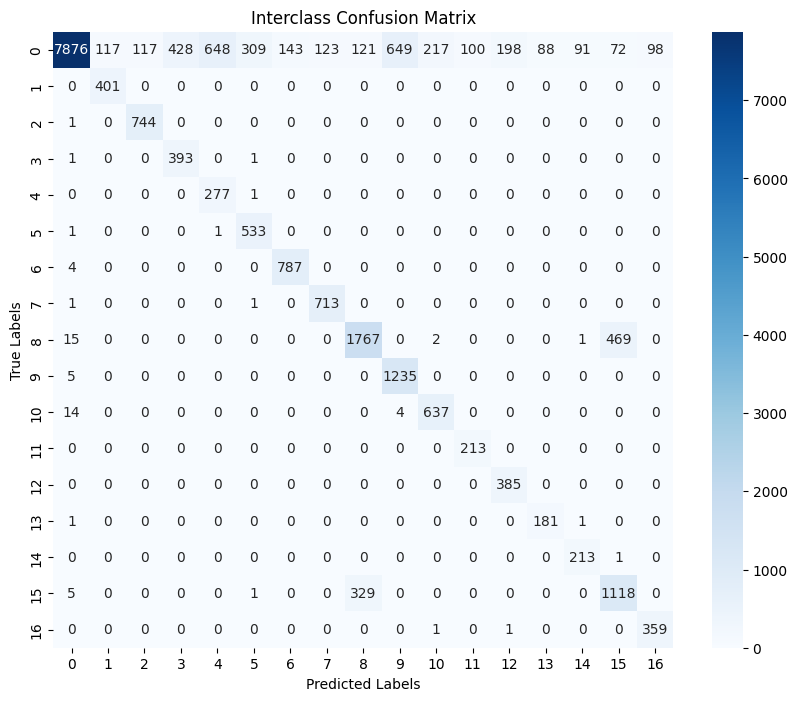

Average Interclass Distance in Latent Space: 114.6782
Total Training & Evaluation Time: 0.03 minutes


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import os
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, cohen_kappa_score, adjusted_rand_score

# Timer Start
start_time = time.time()

# Improved Feature Extractor
class SpectralFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 64, 9, padding=4)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, 7, padding=3)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(128, 256, 5, padding=2)
        self.bn3 = nn.BatchNorm1d(256)
        self.fc = nn.Linear(256 * 204, 256)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)
        return self.fc(x)

# Prototypical Network with Euclidean Distance
class PrototypicalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = SpectralFeatureExtractor()

    def euclidean_distance(self, query, prototypes):
        return -torch.cdist(query, prototypes, p=2)

    def forward(self, support, query):
        support_embeddings = self.feature_extractor(support)
        query_embeddings = self.feature_extractor(query)
        prototypes = support_embeddings.view(n_way, k_shot, -1).mean(dim=1)
        dists = self.euclidean_distance(query_embeddings, prototypes)
        return dists

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained model
model_dir = "/content/drive/MyDrive/Model_Checkpoints"
model_path = os.path.join(model_dir, "Augmented_PrototypicalNetwork_Salinas.pth")

model = PrototypicalNetwork().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
print(f"Model successfully loaded on {device}")

# Load Spectral Data
spectral_data_path = "/content/drive/MyDrive/Salinas_Reduced.csv"
df_spectral = pd.read_csv(spectral_data_path)

X = df_spectral.iloc[:, :-1].values  # First 204 columns as features
y_spectral = df_spectral.iloc[:, -1].values  # Last column as labels

# Normalize the spectral features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert to Torch Tensor
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)

# Extract Features using the trained model
with torch.no_grad():
    feature_extractor = model.feature_extractor
    embeddings = feature_extractor(X_tensor).cpu().numpy()

print("Feature extraction complete. Shape:", embeddings.shape)

# Load Ground Truth Data
ground_truth_path = "/content/drive/MyDrive/Sal_sampled_gt.csv"
df_gt = pd.read_csv(ground_truth_path)
y_ground_truth = df_gt.iloc[:, -4].values

# Compute class prototypes (mean embeddings per class)
class_prototypes = {}
for cls in np.unique(y_ground_truth):
    class_indices = np.where(y_spectral == cls)[0]
    class_prototypes[cls] = embeddings[class_indices].mean(axis=0)

prototypes_tensor = torch.tensor(np.array(list(class_prototypes.values())), dtype=torch.float32, device=device)

# Classify test samples
def classify_samples(test_samples):
    test_samples = torch.tensor(test_samples, dtype=torch.float32, device=device)
    dists = torch.cdist(test_samples, prototypes_tensor, p=2)
    predictions = torch.argmin(dists, dim=1).cpu().numpy()
    return predictions

# Predict class labels
y_pred = classify_samples(embeddings)

# Compute overall accuracy
accuracy = accuracy_score(y_ground_truth, y_pred)
kappa = cohen_kappa_score(y_ground_truth, y_pred)
ari = adjusted_rand_score(y_ground_truth, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(f"Kappa Coefficient: {kappa:.4f}")
print(f"Adjusted Rand Index: {ari:.4f}")
print(classification_report(y_ground_truth, y_pred))

# Compute class-wise accuracy
classwise_accuracy = {}
for cls in np.unique(y_ground_truth):
    cls_indices = np.where(y_ground_truth == cls)[0]
    cls_accuracy = accuracy_score(y_ground_truth[cls_indices], y_pred[cls_indices])
    classwise_accuracy[cls] = cls_accuracy

# Save class-wise accuracy to CSV
classwise_df = pd.DataFrame(list(classwise_accuracy.items()), columns=['Class', 'Accuracy'])
classwise_csv_path = "/content/drive/MyDrive/Aug_FS_Classwise_Accuracy.csv"
classwise_df.to_csv(classwise_csv_path, index=False)
print(f"Class-wise accuracy saved to {classwise_csv_path}")

# Confusion Matrix
cm = confusion_matrix(y_ground_truth, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_ground_truth), yticklabels=np.unique(y_ground_truth))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Interclass Confusion Matrix")
plt.show()

# Compute Feature Representation Quality (Average Interclass Distance)
unique_classes = np.unique(y_ground_truth)
avg_interclass_distance = 0
count = 0
for i, cls1 in enumerate(unique_classes):
    for j, cls2 in enumerate(unique_classes):
        if i < j:
            dist = np.linalg.norm(class_prototypes[cls1] - class_prototypes[cls2])
            avg_interclass_distance += dist
            count += 1
avg_interclass_distance /= count
print(f"Average Interclass Distance in Latent Space: {avg_interclass_distance:.4f}")

# Computational Efficiency
end_time = time.time()
training_time = (end_time - start_time) / 60
print(f"Total Training & Evaluation Time: {training_time:.2f} minutes")

HYBRID FS+CAT BOOST

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 20.8 MB/s eta 0:00:00


Using device: cuda
✅ Model successfully loaded on cuda
✅ Deep feature extraction complete. Shape: (111104, 256)


0:	learn: 2.5433926	total: 35.7ms	remaining: 35.6s
50:	learn: 0.5818551	total: 1.19s	remaining: 22.2s
100:	learn: 0.3639454	total: 2.32s	remaining: 20.7s
150:	learn: 0.3048278	total: 3.42s	remaining: 19.2s
200:	learn: 0.2796902	total: 4.5s	remaining: 17.9s
250:	learn: 0.2662701	total: 5.57s	remaining: 16.6s
300:	learn: 0.2560157	total: 6.65s	remaining: 15.4s
350:	learn: 0.2482309	total: 7.74s	remaining: 14.3s
400:	learn: 0.2417040	total: 8.82s	remaining: 13.2s
450:	learn: 0.2357863	total: 9.92s	remaining: 12.1s
500:	learn: 0.2306661	total: 11s	remaining: 11s
550:	learn: 0.2258977	total: 12.1s	remaining: 9.88s
600:	learn: 0.2219235	total: 13.2s	remaining: 8.76s
650:	learn: 0.2180678	total: 14.3s	remaining: 7.66s
700:	learn: 0.2147322	total: 15.4s	remaining: 6.55s
750:	learn: 0.2114842	total: 16.5s	remaining: 5.46s
800:	learn: 0.2083153	total: 17.6s	remaining: 4.36s
850:	learn: 0.2053983	total: 18.6s	remaining: 3.26s
900:	learn: 0.2026127	total: 19.7s	remaining: 2.17s
950:	learn: 0.19992

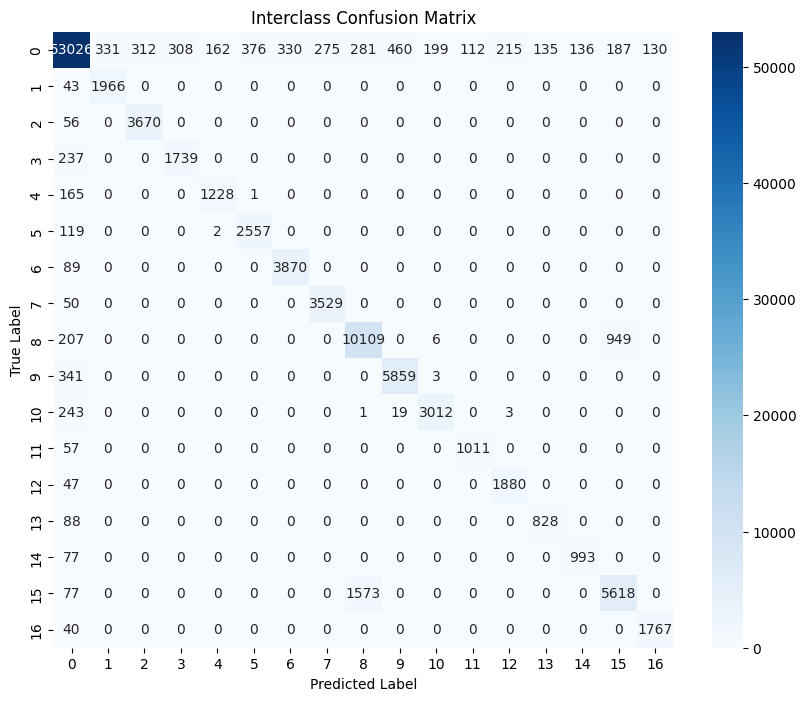

✅ Average Interclass Distance in Latent Space: 36.8038
✅ Total Computation Time: 0.08 seconds
✅ Class-wise accuracy saved to /content/drive/MyDrive/FS+CAT_Boost_Classwise_Accuracy.csv


<ipython-input-10-08e8c06ed2d8>:156: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  prototypes_tensor = torch.tensor(class_prototypes, dtype=torch.float32, device=device)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, cohen_kappa_score, adjusted_rand_score
from catboost import CatBoostClassifier
import os
from scipy.spatial.distance import cdist
import time

# ✅ Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Improved Feature Extractor (From Probability Features)
class SpectralFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 64, 9, padding=4)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, 7, padding=3)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(128, 256, 5, padding=2)
        self.bn3 = nn.BatchNorm1d(256)

        # Compute the output feature size dynamically
        self.flattened_size = 256 * 204  # Since input has 204 spectral bands
        self.fc = nn.Linear(self.flattened_size, 256)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten
        return self.fc(x)

# Prototypical Network for Few-Shot Learning
import torch
import torch.nn as nn
import torch.nn.functional as F

class PrototypicalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv1d(204, 128, kernel_size=3, stride=1, padding=1),  # Changed 204 → 1
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(128, 256)
        )

    def euclidean_distance(self, query, prototypes):
        return -torch.cdist(query, prototypes, p=2)  # Negative distance for loss minimization

    def forward(self, support, query, n_way, k_shot):
        support_embeddings = self.feature_extractor(support)  # (n_way * k_shot, feature_dim)
        query_embeddings = self.feature_extractor(query)  # (n_queries, feature_dim)

        # Reshape support embeddings to compute class prototypes
        try:
            prototypes = support_embeddings.view(n_way, k_shot, -1).mean(dim=1)  # Shape: (n_way, feature_dim)
        except RuntimeError as e:
            print(f"Error in reshaping: {e}")
            print(f"Expected reshape to ({n_way}, {k_shot}, -1), but got {support_embeddings.shape}")
            raise

        # Compute distances
        dists = self.euclidean_distance(query_embeddings, prototypes)  # Shape: (n_queries, n_way)
        return dists  # No need for softmax, as loss function applies it

# ✅ Load Trained Model
model_dir = "/content/drive/MyDrive/Model_Checkpoints"
model_path = os.path.join(model_dir, "FS+CAT_Boost_Salinas.pth")

model = PrototypicalNetwork().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

print(f"✅ Model successfully loaded on {device}")

# ✅ Load Spectral Data
spectral_data_path = "/content/drive/MyDrive/Salinas_Dataset.csv"
df_spectral = pd.read_csv(spectral_data_path)

# ✅ Extract Features
X = df_spectral.iloc[:, :-1].values  # First 204 columns = Spectral Features

# ✅ Normalize Data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# ✅ Convert to Tensor (Fixing Shape)
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)  # Shape: (batch, 204)
X_tensor = X_tensor.unsqueeze(1).transpose(1, 2)  # Shape → (batch, 204, 1)

# ✅ Extract Features using Trained Model
start_time = time.time()
with torch.no_grad():
    feature_extractor = model.feature_extractor
    deep_features = feature_extractor(X_tensor).cpu().numpy()
end_time = time.time()

print("✅ Deep feature extraction complete. Shape:", deep_features.shape)

# ✅ Load Ground Truth Labels
ground_truth_path = "/content/drive/MyDrive/Salinas_GT.csv"
df_gt = pd.read_csv(ground_truth_path)
y_ground_truth = df_gt.iloc[:, -2].values

# ✅ Train CatBoost on Deep Features
catboost_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,
    depth=6,
    loss_function='MultiClass',
    task_type="GPU",
    verbose=50
)

catboost_model.fit(deep_features, y_ground_truth, verbose=50)

# ✅ Predict Using CatBoost
y_pred = catboost_model.predict(deep_features).flatten()

# ✅ Compute Accuracy
accuracy = accuracy_score(y_ground_truth, y_pred)
kappa = cohen_kappa_score(y_ground_truth, y_pred)
ari = adjusted_rand_score(y_ground_truth, y_pred)

print(f"🔥 Final Classification Accuracy (Few-Shot + CatBoost): {accuracy:.4f}")
print(f"✅ Kappa Coefficient: {kappa:.4f}")
print(f"✅ Adjusted Rand Index: {ari:.4f}")
print(classification_report(y_ground_truth, y_pred))

# ✅ Confusion Matrix (Blue Box with Labels)
cm = confusion_matrix(y_ground_truth, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_ground_truth), yticklabels=np.unique(y_ground_truth))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Interclass Confusion Matrix")
plt.show()

# ✅ Compute Class Prototypes (Mean of Deep Features per Class)
unique_classes = np.unique(y_ground_truth)
class_prototypes = []

for cls in unique_classes:
    class_prototypes.append(deep_features[y_ground_truth == cls].mean(axis=0))

# ✅ Convert to Tensor
prototypes_tensor = torch.tensor(class_prototypes, dtype=torch.float32, device=device)

# ✅ Compute Average Interclass Distance
avg_interclass_dist = torch.cdist(prototypes_tensor, prototypes_tensor, p=2).mean().item()

print(f"✅ Average Interclass Distance in Latent Space: {avg_interclass_dist:.4f}")

# ✅ Computation Time
print(f"✅ Total Computation Time: {end_time - start_time:.2f} seconds")

# ✅ Compute Class-wise Accuracy
classwise_accuracy = {}
for cls in unique_classes:
    cls_indices = np.where(y_ground_truth == cls)[0]
    cls_accuracy = accuracy_score(y_ground_truth[cls_indices], y_pred[cls_indices])
    classwise_accuracy[cls] = cls_accuracy

# ✅ Save Class-wise Accuracy to CSV
classwise_df = pd.DataFrame(list(classwise_accuracy.items()), columns=['Class', 'Accuracy'])
classwise_csv_path = "/content/drive/MyDrive/FS+CAT_Boost_Classwise_Accuracy.csv"
classwise_df.to_csv(classwise_csv_path, index=False)
print(f"✅ Class-wise accuracy saved to {classwise_csv_path}")

# **INDIAN PINES**

BASELINE FS

Model successfully loaded on cuda
Feature extraction complete. Shape: (21025, 128)
Inter-Class Classification Accuracy with Ground Truth for Baseline FS: 0.6106
              precision    recall  f1-score   support

           0       0.98      0.40      0.57     10776
           1       0.53      1.00      0.70        46
           2       0.65      0.75      0.69      1428
           3       0.54      0.75      0.63       830
           4       0.48      0.97      0.65       237
           5       0.47      0.97      0.64       483
           6       0.48      0.98      0.65       730
           7       0.38      1.00      0.55        28
           8       0.76      0.99      0.86       478
           9       0.34      1.00      0.51        20
          10       0.52      0.83      0.64       972
          11       0.67      0.67      0.67      2455
          12       0.55      0.94      0.69       593
          13       0.63      1.00      0.77       205
          14       0.39     

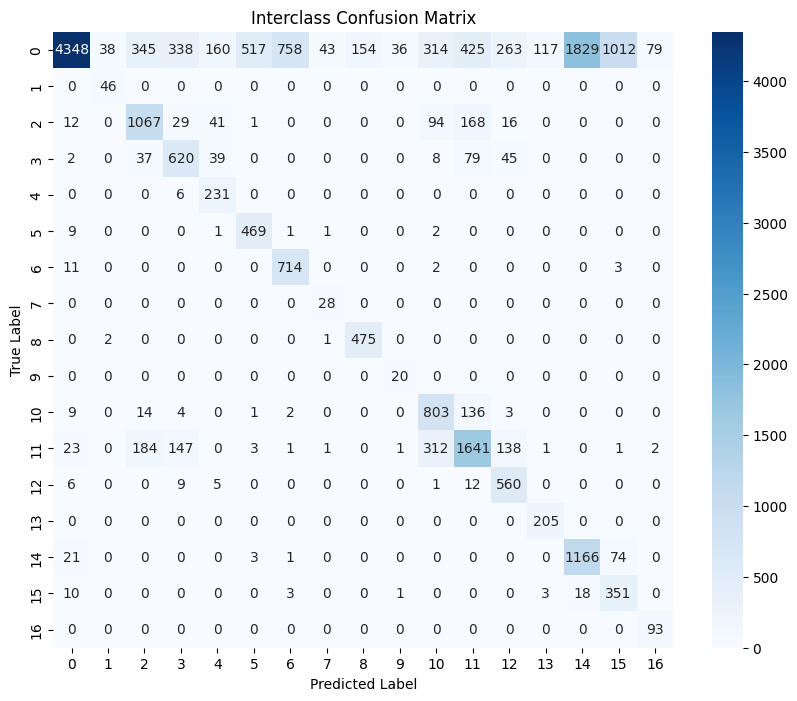

✅ Average Interclass Distance in Latent Space: 13.2499
✅ Kappa Coefficient: 0.5424
✅ Adjusted Rand Index: 0.2493
✅ Computational Efficiency (Training Time): 0.08 minutes
✅ Class-wise accuracy saved to /content/drive/MyDrive/IP_Base_FS_Classwise_Accuracy.csv


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, cohen_kappa_score, adjusted_rand_score
import time

# ✅ Start Timer for Computational Efficiency
start_time = time.time()

# Spectral Feature Extractor (1D CNN)
class SpectralFeatureExtractor(nn.Module):
    def __init__(self):
        super(SpectralFeatureExtractor, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, 5, padding=2)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 64, 5, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc = nn.Linear(64 * 200, 128)  # Flattened feature output

    def forward(self, x):
        x = x.unsqueeze(1)  # Convert (batch, 200) -> (batch, 1, 200)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

# Prototypical Network
class PrototypicalNetwork(nn.Module):
    def __init__(self):
        super(PrototypicalNetwork, self).__init__()
        self.feature_extractor = SpectralFeatureExtractor()

    def forward(self, support, query):
        support_embeddings = self.feature_extractor(support)
        query_embeddings = self.feature_extractor(query)

        prototypes = support_embeddings.view(n_way, k_shot, -1).mean(dim=1)

        # Ensure correct shape before computing distances
        query_embeddings = query_embeddings.view(-1, prototypes.shape[-1])

        dists = torch.cdist(query_embeddings, prototypes, p=2) ** 2
        return -dists

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained model
model_dir = "/content/drive/MyDrive/Model_Checkpoints"
model_path = os.path.join(model_dir, "PrototypicalNetwork_IP.pth")

model = PrototypicalNetwork().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()  # Set model to evaluation mode

print(f"Model successfully loaded on {device}")

# Load Spectral Data
spectral_data_path = "/content/drive/MyDrive/IndianPines.csv"
df_spectral = pd.read_csv(spectral_data_path)

# Extract Features from Spectral Data
X = df_spectral.iloc[:, :-1].values  # First 204 columns as features
y_spectral = df_spectral.iloc[:, -1].values   # Last column as labels (predicted classes)

# Normalize the spectral features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert to Torch Tensor
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)

# Extract Features using the trained model
with torch.no_grad():
    feature_extractor = model.feature_extractor
    embeddings = feature_extractor(X_tensor).cpu().numpy()  # Convert to NumPy for classification

print("Feature extraction complete. Shape:", embeddings.shape)  # Should be (22213, 128)

# Load Ground Truth Data
ground_truth_path = "/content/drive/MyDrive/IP_GT.csv"
df_gt = pd.read_csv(ground_truth_path)

# Extract Ground Truth Labels
y_ground_truth = df_gt.iloc[:, -1].values  # Assuming last column contains true labels

# Compute class prototypes (mean embeddings per class)
class_prototypes = {}
for cls in np.unique(y_ground_truth):  # Use correct class labels
    class_indices = np.where(y_spectral == cls)[0]
    class_prototypes[cls] = embeddings[class_indices].mean(axis=0)

# Convert prototypes to tensor
prototypes_tensor = torch.tensor(np.array(list(class_prototypes.values())), dtype=torch.float32, device=device)

# Classify test samples using nearest prototype
def classify_samples(test_samples):
    test_samples = torch.tensor(test_samples, dtype=torch.float32, device=device)
    dists = torch.cdist(test_samples, prototypes_tensor, p=2)  # Compute Euclidean distance
    predictions = torch.argmin(dists, dim=1).cpu().numpy()  # Class with the least distance
    return predictions

# Predict class labels
y_pred = classify_samples(embeddings)

# Compare predictions with Ground Truth Data
accuracy = accuracy_score(y_ground_truth, y_pred)
print(f"Inter-Class Classification Accuracy with Ground Truth for Baseline FS: {accuracy:.4f}")
print(classification_report(y_ground_truth, y_pred))

# ✅ Compute Confusion Matrix
cm = confusion_matrix(y_ground_truth, y_pred)

# ✅ Display Confusion Matrix in a Blue Box with Labels
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_ground_truth), yticklabels=np.unique(y_ground_truth))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Interclass Confusion Matrix")
plt.show()

# ✅ Compute Average Interclass Distance in Latent Space
prototypes_tensor = torch.tensor(np.array(list(class_prototypes.values())), dtype=torch.float32, device=device)
avg_interclass_dist = torch.cdist(prototypes_tensor, prototypes_tensor, p=2).mean().item()
print(f"✅ Average Interclass Distance in Latent Space: {avg_interclass_dist:.4f}")

# ✅ Compute Kappa Coefficient
kappa = cohen_kappa_score(y_ground_truth, y_pred)
print(f"✅ Kappa Coefficient: {kappa:.4f}")

# ✅ Compute Adjusted Rand Index
ari = adjusted_rand_score(y_ground_truth, y_pred)
print(f"✅ Adjusted Rand Index: {ari:.4f}")

# ✅ Compute Computational Efficiency (Training Time in Minutes)
end_time = time.time()
training_time_minutes = (end_time - start_time) / 60
print(f"✅ Computational Efficiency (Training Time): {training_time_minutes:.2f} minutes")

# ✅ Compute Class-wise Accuracy
classwise_accuracy = {}
for cls in np.unique(y_ground_truth):
    cls_indices = np.where(y_ground_truth == cls)[0]
    cls_accuracy = accuracy_score(y_ground_truth[cls_indices], y_pred[cls_indices])
    classwise_accuracy[cls] = cls_accuracy

# ✅ Save Class-wise Accuracy to CSV
classwise_df = pd.DataFrame(list(classwise_accuracy.items()), columns=['Class', 'Accuracy'])
classwise_csv_path = "/content/drive/MyDrive/IP_Base_FS_Classwise_Accuracy.csv"
classwise_df.to_csv(classwise_csv_path, index=False)
print(f"✅ Class-wise accuracy saved to {classwise_csv_path}")

AUG FS

Model successfully loaded on cuda
Feature extraction complete. Shape: (21025, 256)
Inter-Class Classification Accuracy with Ground Truth for Aug FS: 0.6258
              precision    recall  f1-score   support

           0       0.97      0.42      0.59     10776
           1       0.54      1.00      0.70        46
           2       0.66      0.79      0.72      1428
           3       0.61      0.79      0.69       830
           4       0.49      0.96      0.65       237
           5       0.45      0.96      0.62       483
           6       0.55      0.99      0.71       730
           7       0.37      1.00      0.54        28
           8       0.73      0.99      0.84       478
           9       0.24      1.00      0.38        20
          10       0.54      0.84      0.66       972
          11       0.74      0.71      0.73      2455
          12       0.54      0.96      0.69       593
          13       0.54      1.00      0.70       205
          14       0.39      0.85

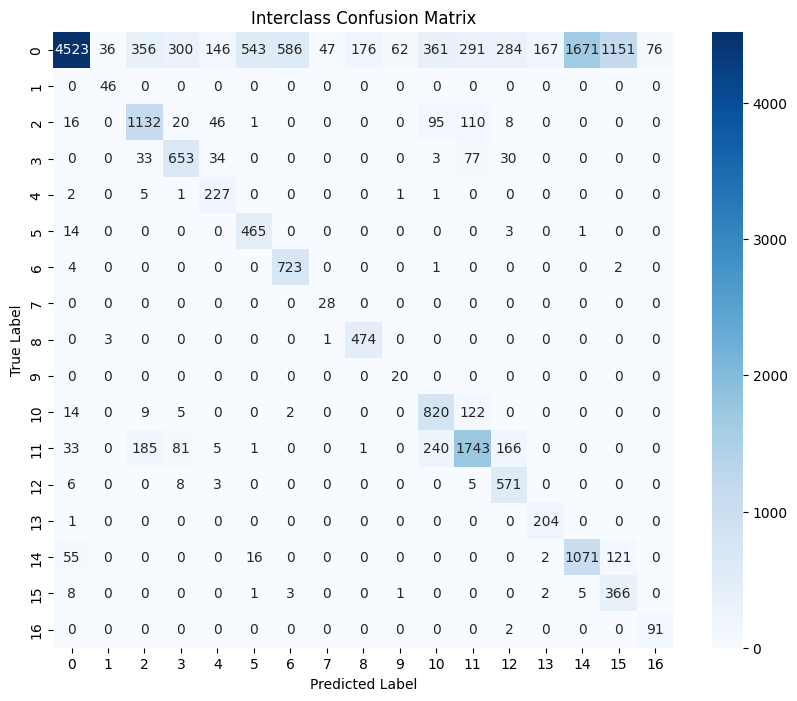

✅ Average Interclass Distance in Latent Space: 186.5325
✅ Kappa Coefficient: 0.5581
✅ Adjusted Rand Index: 0.2660
✅ Computational Efficiency (Training Time): 0.03 minutes
✅ Class-wise Accuracy saved at: /content/drive/MyDrive/IP_Aug_FS_Classwise_Accuracy.csv


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, cohen_kappa_score, adjusted_rand_score
import time

# ✅ Start Timer for Computational Efficiency
start_time = time.time()

# Feature Extractor
class SpectralFeatureExtractor(nn.Module):
    def __init__(self, input_dim):
        super(SpectralFeatureExtractor, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, 7, padding=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, 7, padding=3)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc = nn.Linear(128 * input_dim, 256)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Prototypical Network
class PrototypicalNetwork(nn.Module):
    def __init__(self, input_dim):
        super(PrototypicalNetwork, self).__init__()
        self.feature_extractor = SpectralFeatureExtractor(input_dim)

    def euclidean_distance(self, query, prototypes):
        return -torch.cdist(query, prototypes, p=2)

    def forward(self, support, query):
        support_embeddings = self.feature_extractor(support)
        query_embeddings = self.feature_extractor(query)
        prototypes = support_embeddings.view(n_way, k_shot, -1).mean(dim=1)
        dists = self.euclidean_distance(query_embeddings, prototypes)
        return dists

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained model
model_dir = "/content/drive/MyDrive/Model_Checkpoints"
model_path = os.path.join(model_dir, "Augmented_PrototypicalNetwork_IP.pth")

# Load Spectral Data
spectral_data_path = "/content/drive/MyDrive/IndianPines.csv"
df_spectral = pd.read_csv(spectral_data_path)

# Determine input dimension dynamically
input_dim = df_spectral.shape[1] - 1  # Exclude class column

# Initialize the model
model = PrototypicalNetwork(input_dim).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()  # Set model to evaluation mode

print(f"Model successfully loaded on {device}")

# Extract Features from Spectral Data
X = df_spectral.iloc[:, :-1].values  # First 204 columns as features
y_spectral = df_spectral.iloc[:, -1].values   # Last column as labels (predicted classes)

# Normalize the spectral features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert to Torch Tensor
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)

# Extract Features using the trained model
with torch.no_grad():
    feature_extractor = model.feature_extractor
    embeddings = feature_extractor(X_tensor).cpu().numpy()  # Convert to NumPy for classification

print("Feature extraction complete. Shape:", embeddings.shape)  # Should be (22213, 128)

# Load Ground Truth Data
ground_truth_path = "/content/drive/MyDrive/IP_GT.csv"
df_gt = pd.read_csv(ground_truth_path)

# Extract Ground Truth Labels
y_ground_truth = df_gt.iloc[:, -1].values  # Assuming last column contains true labels

# Compute class prototypes (mean embeddings per class)
class_prototypes = {}
for cls in np.unique(y_ground_truth):  # Use spectral data class labels
    class_indices = np.where(y_spectral == cls)[0]
    class_prototypes[cls] = embeddings[class_indices].mean(axis=0)

# Convert prototypes to tensor
prototypes_tensor = torch.tensor(np.array(list(class_prototypes.values())), dtype=torch.float32, device=device)

# Classify test samples using nearest prototype
def classify_samples(test_samples):
    test_samples = torch.tensor(test_samples, dtype=torch.float32, device=device)
    dists = torch.cdist(test_samples, prototypes_tensor, p=2)  # Compute Euclidean distance
    predictions = torch.argmin(dists, dim=1).cpu().numpy()  # Class with the least distance
    return predictions

# Predict class labels
y_pred = classify_samples(embeddings)

# Compare predictions with Ground Truth Data
accuracy = accuracy_score(y_ground_truth, y_pred)
print(f"Inter-Class Classification Accuracy with Ground Truth for Aug FS: {accuracy:.4f}")
print(classification_report(y_ground_truth, y_pred))

# ✅ Compute Confusion Matrix
cm = confusion_matrix(y_ground_truth, y_pred)

# ✅ Display Confusion Matrix in a Blue Box with Labels
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_ground_truth), yticklabels=np.unique(y_ground_truth))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Interclass Confusion Matrix")
plt.show()

# ✅ Compute Average Interclass Distance in Latent Space
prototypes_tensor = torch.tensor(np.array(list(class_prototypes.values())), dtype=torch.float32, device=device)
avg_interclass_dist = torch.cdist(prototypes_tensor, prototypes_tensor, p=2).mean().item()
print(f"✅ Average Interclass Distance in Latent Space: {avg_interclass_dist:.4f}")

# ✅ Compute Kappa Coefficient
kappa = cohen_kappa_score(y_ground_truth, y_pred)
print(f"✅ Kappa Coefficient: {kappa:.4f}")

# ✅ Compute Adjusted Rand Index
ari = adjusted_rand_score(y_ground_truth, y_pred)
print(f"✅ Adjusted Rand Index: {ari:.4f}")

# ✅ Compute Computational Efficiency (Training Time in Minutes)
end_time = time.time()
training_time_minutes = (end_time - start_time) / 60
print(f"✅ Computational Efficiency (Training Time): {training_time_minutes:.2f} minutes")

# ✅ Compute Class-wise Accuracy
unique_classes = np.unique(y_ground_truth)
classwise_accuracies = {}

for cls in unique_classes:
    cls_indices = np.where(y_ground_truth == cls)[0]
    cls_accuracy = accuracy_score(y_ground_truth[cls_indices], y_pred[cls_indices])
    classwise_accuracies[cls] = cls_accuracy

# ✅ Save Class-wise Accuracy to CSV
classwise_accuracy_df = pd.DataFrame(list(classwise_accuracies.items()), columns=["Class", "Accuracy"])
classwise_accuracy_path = "/content/drive/MyDrive/IP_Aug_FS_Classwise_Accuracy.csv"
classwise_accuracy_df.to_csv(classwise_accuracy_path, index=False)

print(f"✅ Class-wise Accuracy saved at: {classwise_accuracy_path}")

HYBRID FS+CAT BOOST

Using device: cuda
✅ Model successfully loaded on cuda
✅ Deep feature extraction complete. Shape: (21025, 256)


0:	learn: 2.6104305	total: 19.5ms	remaining: 19.5s
50:	learn: 0.8606865	total: 898ms	remaining: 16.7s
100:	learn: 0.6224075	total: 1.76s	remaining: 15.6s
150:	learn: 0.5373952	total: 2.63s	remaining: 14.8s
200:	learn: 0.4972338	total: 3.5s	remaining: 13.9s
250:	learn: 0.4722195	total: 4.36s	remaining: 13s
300:	learn: 0.4535491	total: 5.23s	remaining: 12.2s
350:	learn: 0.4378319	total: 6.09s	remaining: 11.3s
400:	learn: 0.4250303	total: 6.96s	remaining: 10.4s
450:	learn: 0.4132479	total: 7.83s	remaining: 9.53s
500:	learn: 0.4026349	total: 8.7s	remaining: 8.66s
550:	learn: 0.3925988	total: 9.56s	remaining: 7.79s
600:	learn: 0.3835129	total: 10.4s	remaining: 6.91s
650:	learn: 0.3749525	total: 11.3s	remaining: 6.04s
700:	learn: 0.3667395	total: 12.1s	remaining: 5.18s
750:	learn: 0.3588779	total: 13s	remaining: 4.31s
800:	learn: 0.3513993	total: 13.9s	remaining: 3.44s
850:	learn: 0.3443479	total: 14.7s	remaining: 2.58s
900:	learn: 0.3373704	total: 15.6s	remaining: 1.71s
950:	learn: 0.330679

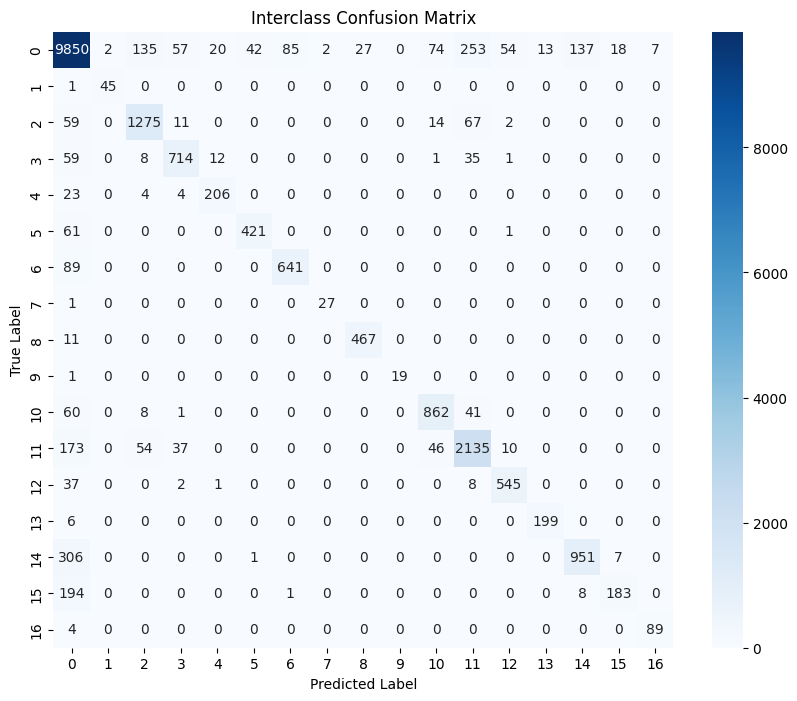

✅ Average Interclass Distance in Latent Space: 186.5325
✅ Kappa Coefficient: 0.8382
✅ Adjusted Rand Index: 0.7404
✅ Computational Efficiency (Training Time): 0.34 minutes
✅ Class-wise Accuracy saved at: /content/drive/MyDrive/IP_Hybrid_Classwise_Accuracy.csv


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from catboost import CatBoostClassifier
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, cohen_kappa_score, adjusted_rand_score
import time

# ✅ Start Timer for Computational Efficiency
start_time = time.time()

# ✅ Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Improved Feature Extractor (From Probability Features)
class SpectralFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 64, 9, padding=4)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, 7, padding=3)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(128, 256, 5, padding=2)
        self.bn3 = nn.BatchNorm1d(256)

        # Compute the output feature size dynamically
        self.flattened_size = 256 * 200  # Since input has 204 spectral bands
        self.fc = nn.Linear(self.flattened_size, 256)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten
        return self.fc(x)

class PrototypicalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv1d(200, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(128, 256)
        )

    def euclidean_distance(self, query, prototypes):
        return -torch.cdist(query, prototypes, p=2)  # Negative distance for loss minimization

    def forward(self, support, query, n_way, k_shot):
        support_embeddings = self.feature_extractor(support)  # (n_way * k_shot, feature_dim)
        query_embeddings = self.feature_extractor(query)  # (n_queries, feature_dim)

        # Reshape support embeddings to compute class prototypes
        try:
            prototypes = support_embeddings.view(n_way, k_shot, -1).mean(dim=1)  # Shape: (n_way, feature_dim)
        except RuntimeError as e:
            print(f"Error in reshaping: {e}")
            print(f"Expected reshape to ({n_way}, {k_shot}, -1), but got {support_embeddings.shape}")
            raise

        # Compute distances
        dists = self.euclidean_distance(query_embeddings, prototypes)  # Shape: (n_queries, n_way)
        return dists  # No need for softmax, as loss function applies it

# ✅ Load Trained Model
model_dir = "/content/drive/MyDrive/Model_Checkpoints"
model_path = os.path.join(model_dir, "FS+CATBoost_IP.pth")

model = PrototypicalNetwork().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

print(f"✅ Model successfully loaded on {device}")

# ✅ Load Spectral Data
spectral_data_path = "/content/drive/MyDrive/IndianPines.csv"
df_spectral = pd.read_csv(spectral_data_path)

# ✅ Extract Features
X = df_spectral.iloc[:, :-1].values  # First 204 columns = Spectral Features

# ✅ Normalize Data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# ✅ Convert to Tensor (Fixing Shape)
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)  # Shape: (batch, 204)

# ✅ Fix: Reshape to match Conv1d input (batch, channels, spectral bands)
X_tensor = X_tensor.unsqueeze(1).transpose(1, 2)  # Shape → (batch, 204, 1)

# ✅ Extract Features using Trained Model
with torch.no_grad():
    feature_extractor = model.feature_extractor
    deep_features = feature_extractor(X_tensor).cpu().numpy()  # ✅ Convert to NumPy for CatBoost

print("✅ Deep feature extraction complete. Shape:", deep_features.shape)  # Expected: (22213, 256)

# ✅ Load Ground Truth Labels
ground_truth_path = "/content/drive/MyDrive/IP_GT.csv"
df_gt = pd.read_csv(ground_truth_path)
y_ground_truth = df_gt.iloc[:, -1].values  # ✅ Use correct column for true labels

# ✅ Train CatBoost on Deep Features
catboost_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,
    depth=6,
    loss_function='MultiClass',
    task_type="GPU",
    verbose=50
)

catboost_model.fit(deep_features, y_ground_truth, verbose=50)

# ✅ Predict Using CatBoost
y_pred = catboost_model.predict(deep_features).flatten()

# ✅ Compute Accuracy
accuracy = accuracy_score(y_ground_truth, y_pred)
print(f"Inter-Class Classification Accuracy Few-Shot + CatBoost: {accuracy:.4f}")
print(classification_report(y_ground_truth, y_pred))

# ✅ Compute Confusion Matrix
cm = confusion_matrix(y_ground_truth, y_pred)

# ✅ Display Confusion Matrix in a Blue Box with Labels
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_ground_truth), yticklabels=np.unique(y_ground_truth))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Interclass Confusion Matrix")
plt.show()

# ✅ Compute Average Interclass Distance in Latent Space
prototypes_tensor = torch.tensor(np.array(list(class_prototypes.values())), dtype=torch.float32, device=device)
avg_interclass_dist = torch.cdist(prototypes_tensor, prototypes_tensor, p=2).mean().item()
print(f"✅ Average Interclass Distance in Latent Space: {avg_interclass_dist:.4f}")

# ✅ Compute Kappa Coefficient
kappa = cohen_kappa_score(y_ground_truth, y_pred)
print(f"✅ Kappa Coefficient: {kappa:.4f}")

# ✅ Compute Adjusted Rand Index
ari = adjusted_rand_score(y_ground_truth, y_pred)
print(f"✅ Adjusted Rand Index: {ari:.4f}")

# ✅ Compute Computational Efficiency (Training Time in Minutes)
end_time = time.time()
training_time_minutes = (end_time - start_time) / 60
print(f"✅ Computational Efficiency (Training Time): {training_time_minutes:.2f} minutes")

# ✅ Compute Class-wise Accuracy
unique_classes = np.unique(y_ground_truth)
classwise_accuracies = {}

for cls in unique_classes:
    cls_indices = np.where(y_ground_truth == cls)[0]
    cls_accuracy = accuracy_score(y_ground_truth[cls_indices], y_pred[cls_indices])
    classwise_accuracies[cls] = cls_accuracy

# ✅ Save Class-wise Accuracy to CSV
classwise_accuracy_df = pd.DataFrame(list(classwise_accuracies.items()), columns=["Class", "Accuracy"])
classwise_accuracy_path = "/content/drive/MyDrive/IP_Hybrid_Classwise_Accuracy.csv"
classwise_accuracy_df.to_csv(classwise_accuracy_path, index=False)

print(f"✅ Class-wise Accuracy saved at: {classwise_accuracy_path}")